In [1]:
! pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 5.2 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

**创建数据**

In [3]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:
X = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Salinas/Salinas_corrected.mat')['salinas_corrected']
y = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Salinas/Salinas_gt.mat')['salinas_gt']
import plotly.express as px

cls = px.imshow(y, color_continuous_scale='jet')

cls.update_layout(title='Ground Truth', coloraxis_showscale=True)
cls.update_xaxes(showticklabels=False)
cls.update_yaxes(showticklabels=False)
cls.show()

In [5]:
#非0的类别都重赋值为1
h=511
w=216
th = 0
for i in range(h):
  for t in range(w):
    if y[i][t] != 0:
      y[i][t] = 1
    print(y[i][t])

流式输出内容被截断，只能显示最后 5000 行内容。
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

In [6]:
cls = px.imshow(y, color_continuous_scale='jet')

cls.update_layout(title='Ground Truth', coloraxis_showscale=True)
cls.update_xaxes(showticklabels=False)
cls.update_yaxes(showticklabels=False)
cls.show()

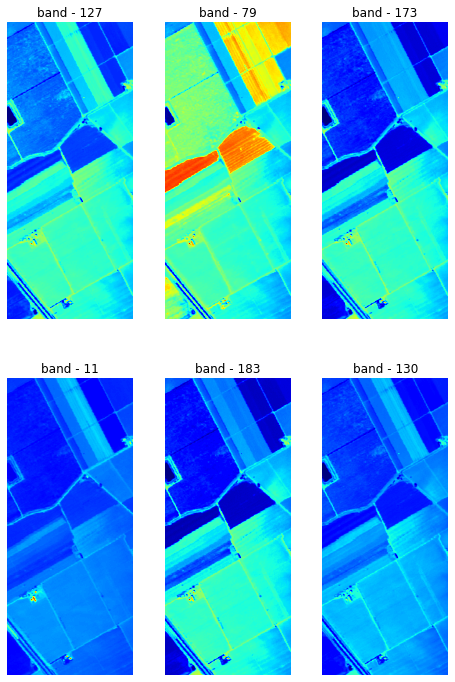

In [ ]:
import seaborn as sns

sns.axes_style('whitegrid')
fig = plt.figure(figsize=(8, 12))

# 不同光谱下的图像示例
for i in range(1, 1+6):
    fig.add_subplot(2, 3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:, :, q], cmap='jet')
    plt.axis('off')
    plt.title(f'band - {q}')

In [7]:
# 地物类别
class_num = 2
#X = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/PaviaU.mat')['paviaU']
#y = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/PaviaU_gt.mat')['paviaU_gt']


# 用于测试样本的比例
test_ratio = 0.9
# 每个像素周围提取 patch 的尺寸
patch_size = 7
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)



# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 3, 1, 2)
Xtest  = Xtest.transpose(0, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape)

Hyperspectral data shape:  (512, 217, 204)
Label shape:  (512, 217)

... ... PCA tranformation ... ...
Data shape after PCA:  (512, 217, 30)

... ... create data cubes ... ...
Data cube X shape:  (54129, 7, 7, 30)
Data cube y shape:  (54129,)

... ... create train & test data ... ...
Xtrain shape:  (5412, 7, 7, 30)
Xtest  shape:  (48717, 7, 7, 30)
after transpose: Xtrain shape:  (5412, 30, 7, 7)
after transpose: Xtest  shape:  (48717, 30, 7, 7)


In [8]:
print(y.shape)

(54129,)


In [9]:
y[5412]

0.0

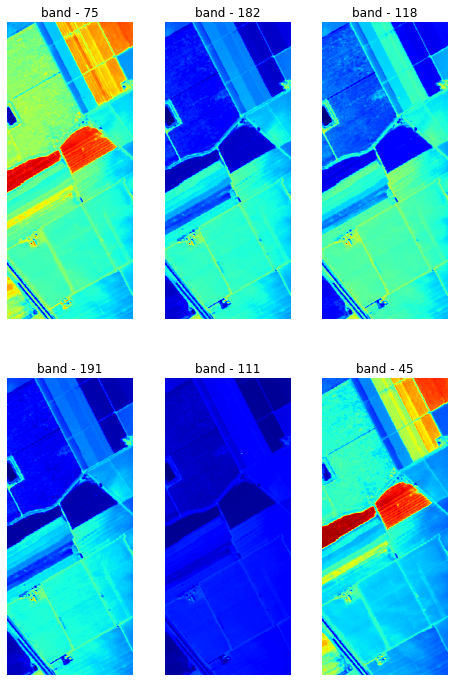

In [10]:
import seaborn as sns

sns.axes_style('whitegrid')
fig = plt.figure(figsize=(8, 12))

# 不同光谱下的图像示例
for i in range(1, 1+6):
    fig.add_subplot(2, 3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:, :, q], cmap='jet')
    plt.axis('off')
    plt.title(f'band - {q}')

In [11]:
""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=32, shuffle=False, num_workers=2)

**创建模型**

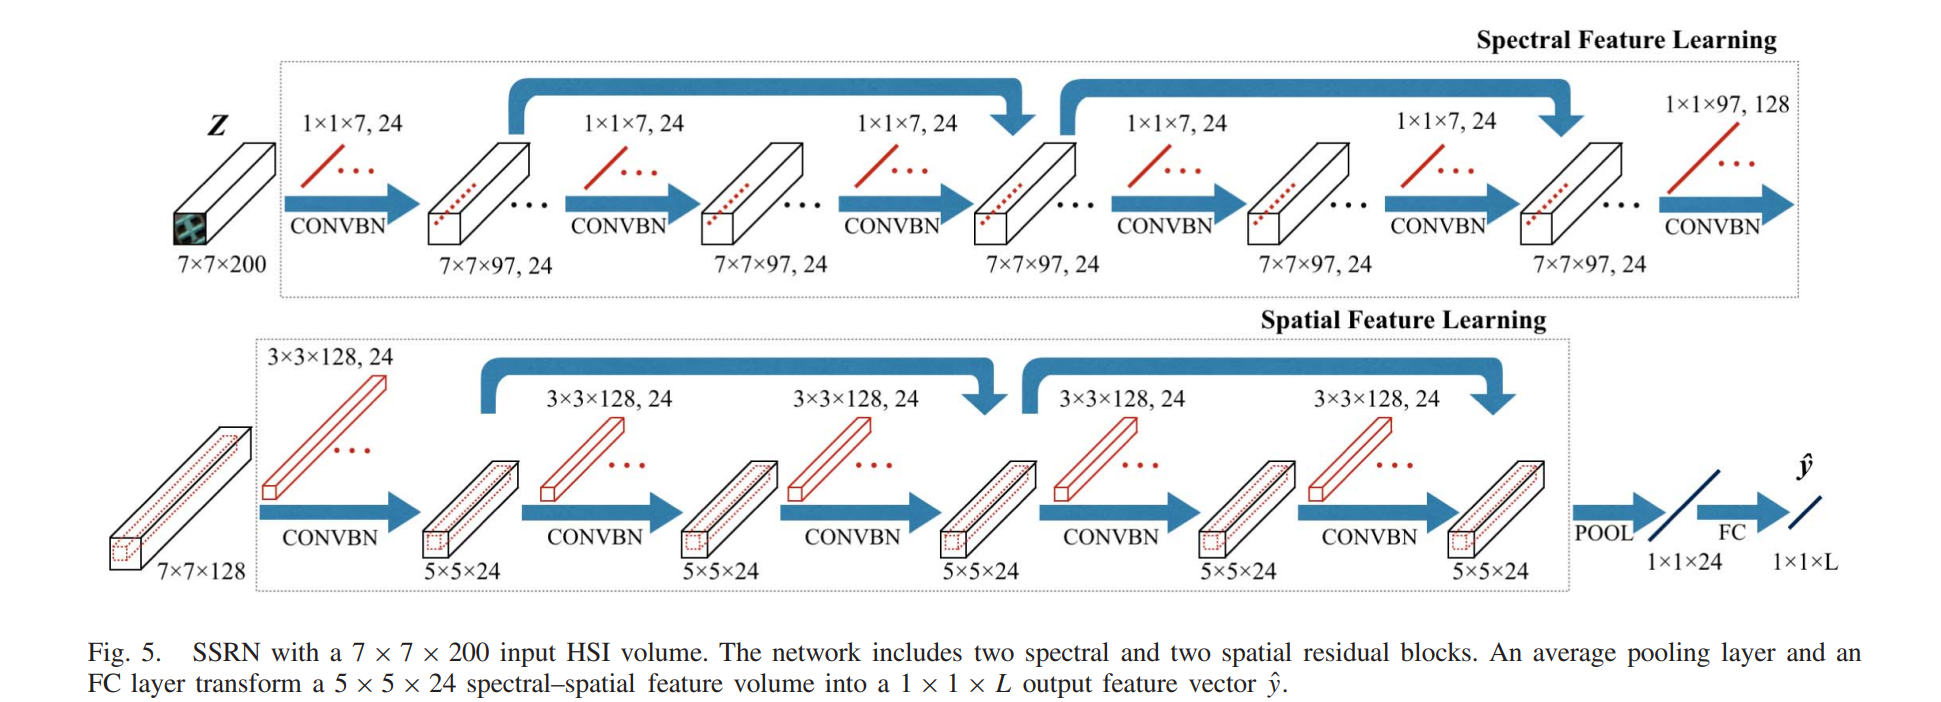

In [12]:
class SSRN(nn.Module):
  def __init__(self):
    super(SSRN,self).__init__()
    self.FE1 = nn.Sequential(
        nn.Conv3d(in_channels=1,out_channels=24,kernel_size=(7,1,1),stride=(2,1,1)),
        nn.BatchNorm3d(24),
    )
    self.spe_conv1 = nn.Sequential(
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),stride=(1,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),stride=(1,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
    )
    self.spe_conv2 = nn.Sequential(
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
        nn.Conv3d(in_channels=24,out_channels=24,kernel_size=(7,1,1),padding=(3,0,0)),
        nn.BatchNorm3d(24),
        nn.ReLU(inplace=True),
    )
    self.CF = nn.Sequential(
        nn.Conv3d(in_channels=24,out_channels=128,kernel_size=(12,1,1),stride=(1,1,1)),
        nn.BatchNorm3d(128),
    )
    self.FE2 = nn.Sequential(
        nn.Conv2d(in_channels=128,out_channels=24,kernel_size=(3,3),stride=(1,1)),
        nn.BatchNorm2d(24),
    )
    self.spa_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=24,out_channels=24,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
        nn.BatchNorm2d(24),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.3),
        nn.Conv2d(in_channels=24,out_channels=24,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
        nn.BatchNorm2d(24),
        nn.Dropout2d(p=0.3),
    )
    self.avgpool = nn.AvgPool2d(kernel_size=5)
    self.classification = nn.Linear(24,2)
  def forward(self,x):
    #print("输入数据的shape为：",x.shape)
    x = torch.unsqueeze(x,dim=1)
    #print("输入数据扩展后的shape为：",x.shape)
    FE1 = self.FE1(x)
    #print("FE1运行后的shape为：",FE1.shape)
    spe_conv1 = self.spe_conv1(FE1)
    spe_conv1_res = spe_conv1+FE1
    spe_conv2 = self.spe_conv2(spe_conv1_res)
    spe_conv2_res = spe_conv2+spe_conv1_res
    #print("spe_conv2_res的shape为：:",spe_conv2_res.shape)
    CF = self.CF(spe_conv2_res)
    #print("CF运行后的shape为：:",CF.shape)
    CF = torch.squeeze(CF,dim=2)
    #print("CF压缩后的shape为:",CF.shape)
    FE2 = self.FE2(CF)
    #print("FE2运行后的shape为：",FE2.shape)
    spa_conv1 = self.spa_conv1(FE2)
    spa_conv1_res = spa_conv1+FE2
    #print("spa_conv1_res的shape为：",spa_conv1_res.shape)
    avg = self.avgpool(spa_conv1_res)
    #print("spa_conv1_res在最大池化后的avg的shape为:",avg.shape)
    avg = torch.squeeze(avg)
    #print("avg在压缩后的shape为：",avg.shape)
    out = self.classification(avg)
    return out

In [13]:
x = torch.randn(566, 30, 7, 7)
net = SSRN()
y = net(x)
print(y.shape)

torch.Size([566, 2])


**训练与测试**

In [14]:
def train(net):


  current_loss_his = []
  current_Acc_his = []

  best_net_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  # 开始训练
  total_loss = 0
  for epoch in range(50):
      net.train()  # 将模型设置为训练模式
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      net.eval()   # 将模型设置为验证模式
      current_acc = test_acc(net)
      current_Acc_his.append(current_acc)

      if current_acc > best_acc:
        best_acc = current_acc
        best_net_wts = copy.deepcopy(net.state_dict())

      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]  [current acc: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item(), current_acc))
      current_loss_his.append(loss.item())

  print('Finished Training')
  print("Best Acc:%.4f" %(best_acc))

  # load best model weights
  net.load_state_dict(best_net_wts)

  return net,current_loss_his,current_Acc_his

In [15]:
def test_acc(net):
  count = 0
  # 模型测试
  for inputs, _ in test_loader:
      inputs = inputs.to(device)
      outputs = net(inputs)
      outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      if count == 0:
          y_pred_test =  outputs
          count = 1
      else:
          y_pred_test = np.concatenate( (y_pred_test, outputs) )

  # 生成分类报告
  classification = classification_report(ytest, y_pred_test, digits=4)
  index_acc = classification.find('weighted avg')
  accuracy = classification[index_acc+17:index_acc+23]
  return float(accuracy)

In [16]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = SSRN().to(device)
# 训练
net,current_loss_his,current_Acc_his = train(net)

[Epoch: 1]   [loss avg: 56.5867]   [current loss: 0.1277]  [current acc: 1.0000]
[Epoch: 2]   [loss avg: 31.9350]   [current loss: 0.0184]  [current acc: 1.0000]
[Epoch: 3]   [loss avg: 21.9108]   [current loss: 0.0058]  [current acc: 1.0000]
[Epoch: 4]   [loss avg: 16.6311]   [current loss: 0.0029]  [current acc: 1.0000]
[Epoch: 5]   [loss avg: 13.3952]   [current loss: 0.0018]  [current acc: 1.0000]


KeyboardInterrupt: ignored

In [ ]:
X = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Salinas/Salinas_corrected.mat')['salinas_corrected']
y = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Salinas/Salinas_gt.mat')['salinas_gt']
#非0的类别都重赋值为1
h=511
w=216
th = 0
for i in range(h):
  for t in range(w):
    if y[i][t] != 0:
      y[i][t] = 1

In [ ]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# load the original image


height = 512
width = 217

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i][j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            #print(image_patch.shape)
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2])
            #print(image_patch.shape)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=0)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...
... ... row  160  handling ... ...
... ... row  180  handling ... ...
... ... row  200  handling ... ...
... ... row  220  handling ... ...
... ... row  240  handling ... ...
... ... row  260  handling ... ...
... ... row  280  handling ... ...
... ... row  300  handling ... ...
... ... row  320  handling ... ...
... ... row  340  handling ... ...
... ... row  360  handling ... ...
... ... row  380  handling ... ...
... ... row  400  handling ... ...
... ... row  420  handling ... ...
... ... row  440  handling ... ...
... ... row  460  handling ... ...
... ... row  480  handling ... ...
... ... row  500  handling ... ...


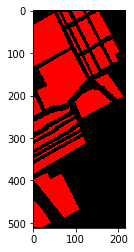

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(10,4))